# Single-Model Learning

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas

# See https://keras.io/
# for extennsive documentation
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

import sklearn.utils

import pickle
def fnSaveObject(save_object, sFileName):
    with open(sFileName, "wb") as file:
        pickle.dump(save_object, file)

def fnLoadObject(sFileName):
    with open(sFileName, 'rb') as file:
        load_object = pickle.load(file)
    return load_object

ImportError: cannot import name 'keras' from 'tensorflow' (unknown location)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# load all examples from the file
data_x_pandas = fnLoadObject('train_core_shell_cylinder_x.dat')
data_y_pandas = fnLoadObject('train_core_shell_cylinder_y.dat')

# post-process y-values
for frame in data_y_pandas:
    index_names = frame[ frame['par'] == 'scale'].index
    frame.drop(index_names, inplace = True)

    solvent_sld = frame.loc[frame.par =='sld_solvent', 'value'].squeeze()
    sld_shell = frame.loc[frame.par == 'sld_shell', 'value'].squeeze()
    sld_core = frame.loc[frame.par == 'sld_core', 'value'].squeeze()
    frame.loc[frame.par == 'sld_shell', 'value'] = solvent_sld - sld_shell
    frame.loc[frame.par == 'sld_core', 'value'] = solvent_sld - sld_core

    index_names = frame[ frame['par'] == 'sld_solvent'].index
    frame.drop(index_names, inplace = True)

print(data_y_pandas[0])

data_x = numpy.row_stack([frame['I'].to_numpy() for frame in data_x_pandas]).astype('float32')
# use log for data
data_x = numpy.log10(data_x)
data_y = numpy.row_stack([frame['value'].to_numpy() for frame in data_y_pandas]).astype('float32')

print("data_x:", data_x.shape)
print("data_y:", data_y.shape)
len_set = data_x.shape[0]
len_train = int(len_set * 2 / 3)

# Prepare for proper training
# randomly sort examples
data_x, data_y = sklearn.utils.shuffle(data_x, data_y, random_state=0)

# take the first 2/3 of examples for training
X_train = data_x[:len_train, :]
y_train = data_y[:len_train, :]

# and the remaining examples for testing
X_test = data_x[len_train:, :] # all features except last column
y_test = data_y[len_train:, :] # quality column

print("First example:")
print("Features:", X_train[0])
print("Quality:", y_train[0])

         par       value
0     length   56.295012
1     radius   89.465754
3   sld_core   -1.732633
4  sld_shell    1.478057
6  thickness  135.183328
data_x: (10000, 105)
data_y: (10000, 5)
First example:
Features: [ 2.6072164   2.5514114   2.495166    2.4245849   2.3610196   2.2754357
  2.2102346   2.1309044   2.0517771   1.9434946   1.8412305   1.7256414
  1.6075983   1.4809581   1.3523091   1.2347343   1.1404898   1.0358402
  0.98409224  0.93584013  0.91675496  0.90045804  0.8869194   0.87947065
  0.8655578   0.8158182   0.77789456  0.71711195  0.6373241   0.5368711
  0.40495375  0.2380096   0.09657759 -0.04188217 -0.06833199 -0.13816439
 -0.07669698 -0.01357331 -0.10738505 -0.16360329 -0.26740944 -0.58318096
 -0.47953683 -0.5355665  -0.64447254 -0.70696855 -0.6618321  -0.6550097
 -0.8285262  -0.9956574  -0.80254877 -1.0836476  -1.1206093  -1.1277496
 -1.4982321  -1.7737143  -1.2613407  -1.259369   -1.4922254  -1.6471865
 -1.6048355  -1.7353572  -1.4325978  -1.4702992  -1.3844901  -

In [4]:
# See: https://keras.io/api/models/sequential/ and
# https://keras.io/api/layers/core_layers/dense/
# We can use the Sequential class to very easiliy
# build a simple architecture
model = Sequential()
# 11 inputs, 20 outputs, relu
input_dim = data_x.shape[1]
output_dim = data_y.shape[1]
node_n = input_dim

activation = "relu"
reg_strategy = keras.regularizers.l1_l2(l1=0.001, l2=0.001)  # use L1 and L2 regularization


model.add(Dense(node_n, input_dim=input_dim, activation=activation, kernel_regularizer=reg_strategy))
model.add(Dense(node_n, activation=activation, kernel_regularizer=reg_strategy))
model.add(Dense(node_n, activation=activation, kernel_regularizer=reg_strategy))
model.add(Dense(node_n, activation=activation, kernel_regularizer=reg_strategy))
model.add(Dense(node_n, activation=activation, kernel_regularizer=reg_strategy))
model.add(Dense(int(node_n/2), activation=activation, kernel_regularizer=reg_strategy))
model.add(Dense(int(node_n/4), activation=activation, kernel_regularizer=reg_strategy))
# 20 inputs (automatically detected by Keras), 1 output, linear activation
model.add(Dense(output_dim, activation='linear'))


# Set loss function and optimiser algorithm
# Remove comments from of these versions:

# Initial:
#model.compile(loss='mse',  # mean squared error
#              optimizer='sgd'# stochastic gradient descent
#             )
#
# sgd with momentum
# instead of passing a string, we can explicitly construct the optimizer object
# this gives us more control over its properties
#opt = keras.optimizers.SGD(momentum=0.8)
#model.compile(loss='mse',  # mean squared error
#              optimizer='sgd'
#             )
#
# Adam:
opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss="mse",
              optimizer=opt
             )
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 105)               11130     
                                                                 
 dense_1 (Dense)             (None, 105)               11130     
                                                                 
 dense_2 (Dense)             (None, 105)               11130     
                                                                 
 dense_3 (Dense)             (None, 105)               11130     
                                                                 
 dense_4 (Dense)             (None, 105)               11130     
                                                                 
 dense_5 (Dense)             (None, 52)                5512      
                                                                 
 dense_6 (Dense)             (None, 26)                1

In [5]:
epochs_n = 500
batch_size = 16

save_period = 20  # after how many epochs the model should be saved?
chkpnt_saver = keras.callbacks.ModelCheckpoint("weights-{epoch:02d}.hdf5", save_weights_only=True, save_freq=save_period)


history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs_n,
                    batch_size=batch_size,
                    verbose=1
                    )

# callbacks=[chkpnt_saver])

Epoch 1/500
417/417 [==============================] - 1s 3ms/step - loss: 2182.5488 - val_loss: 1719.9554
Epoch 2/500
417/417 [==============================] - 1s 2ms/step - loss: 1721.5786 - val_loss: 1742.6897
Epoch 3/500
417/417 [==============================] - 1s 2ms/step - loss: 1642.2507 - val_loss: 1546.9061
Epoch 4/500
417/417 [==============================] - 1s 2ms/step - loss: 1565.7052 - val_loss: 1509.0951
Epoch 5/500
417/417 [==============================] - 1s 2ms/step - loss: 1525.4791 - val_loss: 1437.3898
Epoch 6/500
417/417 [==============================] - 1s 2ms/step - loss: 1447.4922 - val_loss: 1396.2935
Epoch 7/500
417/417 [==============================] - 1s 2ms/step - loss: 1401.4147 - val_loss: 1374.2804
Epoch 8/500
417/417 [==============================] - 1s 2ms/step - loss: 1364.5486 - val_loss: 1349.6115
Epoch 9/500
417/417 [==============================] - 1s 2ms/step - loss: 1340.5277 - val_loss: 1321.2794
Epoch 10/500
417/417 [===============

In [6]:
# The history object returned by the model training above
# contains the values of the loss function (the mean-squared-error)
# at different epochs
# We discard the first epoch as the loss value is very high,
# obscuring the rest of the distribution
train_loss = history.history["loss"][1:]
test_loss = history.history["val_loss"][1:]

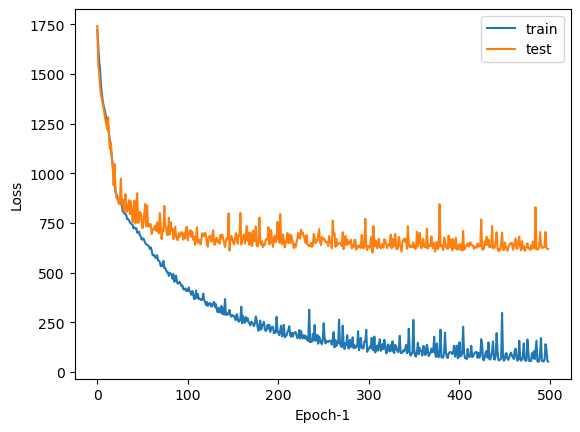

In [7]:
# Prepare and plot loss over time
plt.plot(train_loss,label="train")
plt.plot(test_loss,label="test")
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("Loss")
plt.show()

In [8]:
# After the training:

# Prepare scatter plot
y_pred = model.predict(X_test)


105/105 [==============================] - 0s 947us/step


length
Correlation coefficient: [[1.         0.65631678]
 [0.65631678 1.        ]]


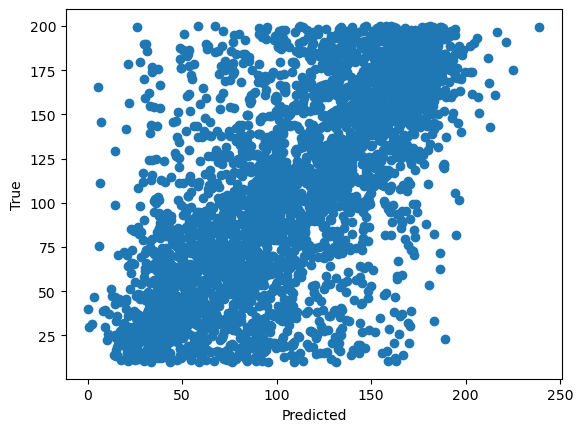

radius
Correlation coefficient: [[1.         0.88890734]
 [0.88890734 1.        ]]


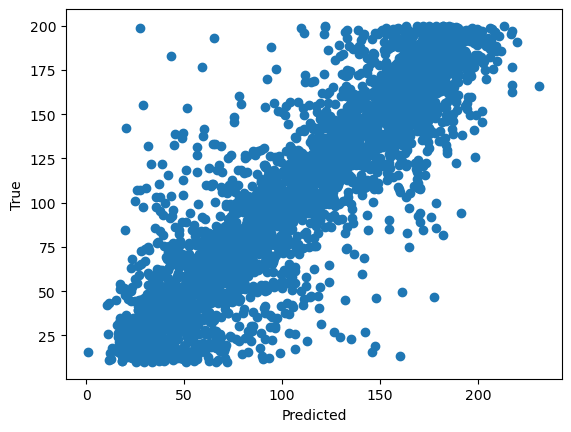

sld_core
Correlation coefficient: [[1.         0.46688525]
 [0.46688525 1.        ]]


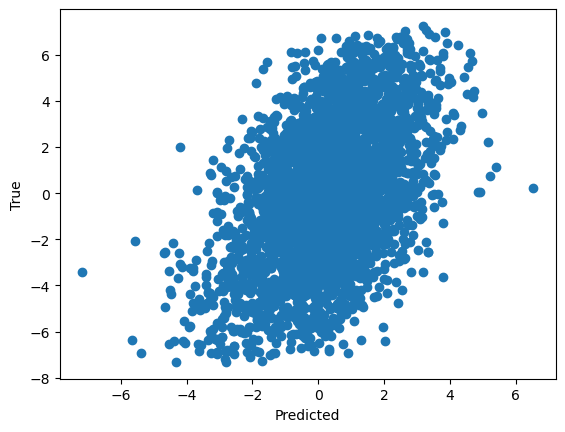

sld_shell
Correlation coefficient: [[1.         0.50919264]
 [0.50919264 1.        ]]


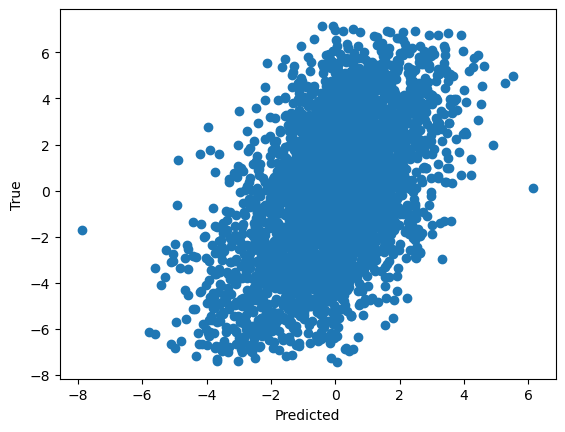

thickness
Correlation coefficient: [[1.        0.9021569]
 [0.9021569 1.       ]]


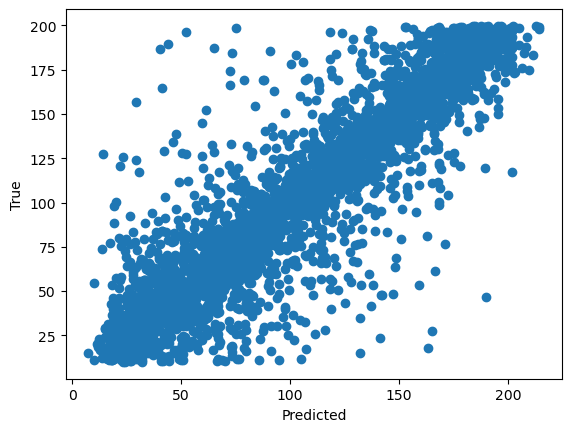

In [9]:
for i in range(y_pred.shape[1]):
    print(data_y_pandas[0]['par'].iloc[i])
    print("Correlation coefficient:", numpy.corrcoef(y_pred[:, i],y_test[:, i]))
    plt.scatter(y_pred[:, i],y_test[:, i])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()